### Sustainability Aware Asset Management: **Groupe A: North America // Scope 1 + 2**
#### **Part I - Standard Asset Allocation**

In [1]:
## Packages lists:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import squarify 
sns.set_style("darkgrid")
sns.set_context("talk", font_scale=1.3)
import datetime as dt
from scipy.optimize import minimize

## Importing all the dataframes from data.ipynb
%run data.ipynb

0
595


In [2]:
## Converting into returns using the simple return definition. Also replacing the NaN in the first period by 0.
df_m = monthly_return.pct_change()
monthly_means = df_m.iloc[1:].mean()
df_m.fillna(monthly_means, inplace=True)
df_m.index = pd.to_datetime(df_m.index)

df_y = yearly_return.pct_change()
yearly_means = df_y.iloc[1:].mean()
df_y.fillna(yearly_means, inplace=True)

### Part I - Standard Asset Allocation

#### 1.1 - Construction of a minimum variance portfolio

As we are computing the minimum variance portfolio out-of-sample, we use the first 6 years of monthly returns (from Jan. 2000 to Dec. 2005) to compute the vector of expected returns and the covariance matrix

In [3]:
## Sampling the dataframe from Jan. 2000 to Dec. 2005
start = dt.datetime(2000, 1, 1)
end = dt.datetime(2005, 12, 31)
stocks = df_m.columns
sample_m = df_m[df_m.index.isin(pd.date_range(start, end))]
## Checking if tau is equal to 72
tau = len(sample_m)
tau == 72

True

We computed the expected returns as:
$$
\hat{\mu}_{Y+1} = \frac{1}{\tau}\sum_{k=0}^{\tau-1} R_{t-k}
$$

In [4]:
## It is simply a basic mean function.
mu_hat = pd.DataFrame(sample_m.mean(axis=0)).T

The covariance matrix is computed as:
$$
\Sigma_{Y+1} = \frac{1}{\tau}\sum_{k=0}^{\tau-1} (R_{t-k} - \hat{\mu}_{Y+1})'(R_{t-k} - \hat{\mu}_{Y+1})
$$

In [5]:
## We use the parameter bias=True, because we divide the sum by 1/tau instead of 1/(tau-1)
excess_returns = sample_m.subtract(mu_hat.values.squeeze(), axis=1)
covmat = 1/tau * excess_returns.T @ excess_returns

## We control if there is a missing value in our covariance matrix
print(covmat.isnull().values.any())

False


For the allocation, we use the following maximizazion problem, while restricting the optimal weights to be positive:

$$\min_{{{\alpha_{Y}}}}\quad \sigma^{2}_{p,Y+1} = \alpha'_{Y}\Sigma_{Y+1}\alpha_{Y}$$

$$\text{s.t.}\quad \alpha'_{Y}e = 1$$

$$\text{s.t.}\quad  \alpha_{i,Y} \ge 0 \quad \text{for all i}$$

In [6]:
# Define objective function (portfolio variance)
def portfolio_variance(weights, covmat):
    return np.dot(weights.T, np.dot(covmat, weights))

# Define constraint (sum of weights equals 1)
def constraint(weights):
    return np.sum(weights) - 1
    
# Number of assets
n_assets = len(covmat)

# Initial guess for weights
initial_weights = np.ones(n_assets) / n_assets

# Define bounds for weights (0 to 1) long-only portfolio
bounds = [(0, None)] * n_assets

# Perform optimization
result = minimize(portfolio_variance, initial_weights, args=(covmat,), constraints={'type': 'eq', 'fun': constraint}, bounds=bounds)

# Get optimal weights
optimal_weights = result.x

# Print results
weights = pd.DataFrame(optimal_weights, index=covmat.index, columns=['weight'])
weights

,weight
SCHLUMBERGER,0.000000e+00
ARCH CAP.GP.,4.071847e-19
EVEREST GROUP,0.000000e+00
NABORS INDUSTRIES,1.339820e-20
RENAISSANCERE HDG.,1.219385e-02
...,...
XCEL ENERGY,0.000000e+00
XEROX HOLDINGS,0.000000e+00
YUM! BRANDS,5.808226e-04
ZEBRA TECHNOLOGIES 'A',2.075877e-03


## Rebalance portfolio from Dec. 2005 to Dec. 2021. (We start to use the rolling windows here)

In [7]:
def roll_min_var_opt(df, start, end):
    stocks = df.columns
    year_weight = end.year + 1
    weights_df = pd.DataFrame(index=stocks)

    for i in range(18):
        ## Resample from start to end
        sample_m = df[df.index.isin(pd.date_range(start, end))]
        tau = len(sample_m)

        ## Compute expected returns
        mu_hat = pd.DataFrame(sample_m.mean(axis=0)).T
    
        ## Excess returns
        excess_returns = sample_m.subtract(mu_hat.values.squeeze(), axis=1)
    
        ## Covariance Matrix
        covmat = 1/tau * excess_returns.T @ excess_returns
    
        # Define objective function (portfolio variance)
        def portfolio_variance(weights, covmat):
            return np.dot(weights.T, np.dot(covmat, weights))
    
        # Define constraint (sum of weights equals 1)
        def constraint(weights):
            return np.sum(weights) - 1
    
        n_assets = len(covmat)
    
        # Initial guess for weights
        initial_weights = np.ones(n_assets) / n_assets
        
        # Define bounds for weights (0 to 1) long-only portfolio
        bounds = [(0, None)] * n_assets
    
        result = minimize(portfolio_variance, initial_weights, args=(covmat,), constraints={'type': 'eq', 'fun': constraint}, bounds=bounds)
    
        optimal_weights = result.x

        weights_df[year_weight] = optimal_weights

        start = dt.datetime(start.year + 1, 1, 1)
        end = dt.datetime(end.year + 1, 1, 1)
        year_weight += 1

    return weights_df

In [8]:
start = dt.datetime(2000, 1, 1)
end = dt.datetime(2005, 12, 31)

weights_df = roll_min_var_opt(df_m, start, end)

In [9]:
## Transform the weights dataframe to an alphas dataframe, which contains the monthly intermediate weights of the portfolio:
def from_weights_to_alphas(weights_df):
    # Initialize an empty DataFrame to hold all alphas
    alphas_df = pd.DataFrame()

    for year in range(2006, 2022+1):
        # Create a subdataframe for the year Y:
        alpha_subdf = pd.DataFrame(index=df_m.columns, columns=pd.date_range(dt.datetime(year-1, 12, 31), dt.datetime(year, 11, 30), freq='M'))

        # Replace the first column by the weights found for the year Y
        alpha_subdf.iloc[:, 0] = weights_df[year]

        # Create a subdataframe which contains each stock's return during the year Y
        returns_subdf = df_m[df_m.index.isin(pd.date_range(dt.datetime(year, 1, 1), dt.datetime(year, 12, 31)))].T

        # Complete the alpha_subdf
        for date in range(1, 12):
            for stock in range(df_m.shape[1]):
                stock_ret = returns_subdf.iloc[stock, date-1]
                pf_ret = returns_subdf.iloc[:, date-1] @ alpha_subdf.iloc[:, date-1]
                alpha_subdf.iloc[stock, date] = alpha_subdf.iloc[stock, date-1] * ((1 + stock_ret) / (1 + pf_ret))
                
        # Append the completed alpha_subdf to alphas_df
        alphas_df = pd.concat([alphas_df, alpha_subdf], axis=1)

    return alphas_df

## Transform the alphas dataframe to a performance dataframe, which contains the monthly performance of the portfolio:
def from_alphas_to_perf(alphas_df):
    ## Filter the monthly returns of each stock from 2006-01-01 to 2022-12-31
    returns = df_m[df_m.index.isin(pd.date_range(dt.datetime(2006, 1, 1), dt.datetime(2022, 12, 31)))].T

    ## Create a list to store the performances of the portfolio for each month
    performances = []

    ## For loop to compute the performance of the portfolio for each month
    for i in range(returns.shape[1]):
        perf = alphas_df.iloc[:,i] @ returns.iloc[:,i]
        performances.append(perf)

    ## Format the performances list into a pandas Series
    return pd.Series(performances, index=returns.columns)

In [12]:
from_alphas_to_perf(from_weights_to_alphas(weights_df))

2006-01-31    0.030375
2006-02-28    0.020039
2006-03-31    0.020022
2006-04-30    0.013991
2006-05-31   -0.017173
                ...   
2022-08-31   -0.019420
2022-09-30   -0.058604
2022-10-31    0.067923
2022-11-30    0.044778
2022-12-31   -0.037976
Length: 204, dtype: float64

In [28]:
performances.T.squeeze()

2006-01-31    0.030375
2006-02-28    0.020039
2006-03-31    0.020022
2006-04-30    0.013991
2006-05-31   -0.017173
                ...   
2022-08-31   -0.019420
2022-09-30   -0.058604
2022-10-31    0.067923
2022-11-30    0.044778
2022-12-31   -0.037976
Name: performance, Length: 204, dtype: float64

## Ex-post performance computation

In [14]:
debut = dt.date(2005,12,31)
fin = dt.date(2022,12,31)

sample_returns = df_m[df_m.index.isin(pd.date_range(debut, fin))]
weights_sample = pd.DataFrame(columns=sample_returns.index, index=sample_returns.columns)

## replace all the weights of December N-1 by the weights in the weights_df
for i in range(weights_sample.shape[1]):
    if weights_sample.columns[i].month == 12:
        weights_sample.iloc[:,i] = weights_df[weights_sample.columns[i].year + 1]

In [15]:
year = 2006
debut1 = dt.date(year, 1,1)
fin1 = dt.date(year, 12, 31)

## Returns of each stock between debut1 and fin1
sample_returns = df_m[df_m.index.isin(pd.date_range(debut1, fin1))].T

## alphas between December Y-1 and November Y
test = weights_sample.iloc[:,weights_sample.columns.year == year].iloc[: , :-1]
test.insert(0, dt.date(year-1,12,31), weights_df[year])

In [16]:
## DataFrame of the alphas
alpha_data = pd.DataFrame()

for x in range(2006,2023):
    year = x
    debut1 = dt.date(year, 1,1)
    fin1 = dt.date(year, 12, 31)

    sample_returns = df_m[df_m.index.isin(pd.date_range(debut1, fin1))].T
    test = weights_sample.iloc[:,weights_sample.columns.year == year].iloc[: , :-1]
    test.insert(0, dt.date(year-1,12,31), weights_df[year])
    
    for j in range(1,12):
        for i in range(595):
            x = sample_returns.iloc[i,j-1] ## STOCK, DATE
            y = test.iloc[:,j-1] @ sample_returns.iloc[:,j-1] ## January 2006 Performance
            previous_a = test.iloc[i,j-1] ## STOCK, DATE
            
            new_a = previous_a * ((1+x)/(1+y))
            test.iloc[i,j] = new_a

    alpha_data = pd.concat([alpha_data, test], axis=1)

alpha_data = alpha_data.T
alpha_data.index = pd.to_datetime(alpha_data.index)
alpha_data = alpha_data.T

In [17]:
## Ex-post performance calculation
debut2 = dt.date(2006,1,1)
fin2 = dt.date(2022,12,31)
returns06_22 = df_m[df_m.index.isin(pd.date_range(debut2, fin2))].T

performances = []

for i in range(returns06_22.shape[1]):
    performance = returns06_22.iloc[:,i] @ alpha_data.iloc[:,i]
    performances.append(performance)

performances = pd.DataFrame(performances, columns=['performance'], index=returns06_22.columns).T

In [18]:
performances

,2006-01-31,2006-02-28,2006-03-31,2006-04-30,2006-05-31,2006-06-30,2006-07-31,2006-08-31,2006-09-30,2006-10-31,...,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31,2022-09-30,2022-10-31,2022-11-30,2022-12-31
performance,0.030375,0.020039,0.020022,0.013991,-0.017173,-0.004062,0.027875,0.024915,0.005425,0.030418,...,0.080934,-0.054911,0.002177,-0.038832,0.035035,-0.01942,-0.058604,0.067923,0.044778,-0.037976


### Compute the characteristics of this portfolio over the sample: annualized average return ($\bar{\mu}_{p}$), annualized volatility $(\sigma_{p})$, Sharpe ratio $(SR_{p})$, minimum, maximum, and maximum drawdown.

In [23]:
def portfolio_characteristics(performances, portfolio_name):
    averagereturn = performances.mean()
    ann_averagereturn = (12 * averagereturn)

    sigma_m = (1/len(performances) * np.sum(performances.subtract(averagereturn) ** 2)) ** (1/2)
    sigma_y = np.sqrt(12) * sigma_m

    rf = risk_free/100
    rf = rf[rf.index.isin(performances.index)]

    sharpe_m = (performances.subtract(rf.values.squeeze()).mean()/sigma_m).mean()
    sharpe_y = (np.sqrt(12) * sharpe_m)

    minimum = np.min(performances)
    maximum = np.max(performances)

    cum_ret = (1+performances).cumprod()
    peaks = cum_ret.cummax()
    drawdowns = (cum_ret - peaks) / peaks
    MDD = drawdowns.min()

    dataframe = pd.DataFrame(index=['Annualized Average Return', 'Annualized Volatility', 'Sharpe Ratio', 'Minimum', 'Maximum', 'Maximum Drawdown'], columns=[portfolio_name])
    dataframe.iloc[0,0] = ann_averagereturn
    dataframe.iloc[1,0] = sigma_y
    dataframe.iloc[2,0] = sharpe_y
    dataframe.iloc[3,0] = minimum
    dataframe.iloc[4,0] = maximum
    dataframe.iloc[5,0] = MDD

    return dataframe

In [24]:
rf = risk_free/100
rf = rf[rf.index.isin(performances.index)]
rf

,RF


In [25]:
rf = risk_free/100
rf

,RF
2000-01-31,0.0041
2000-02-29,0.0043
2000-03-31,0.0047
2000-04-30,0.0046
2000-05-31,0.0050
...,...
2023-09-30,0.0043
2023-10-31,0.0047
2023-11-30,0.0044
2023-12-31,0.0043


In [26]:
rf.iloc[rf.index.isin(performances.index),:]

,RF


In [27]:
portfolio_mv = portfolio_characteristics(performances.squeeze(), 'Portfolio MV')
portfolio_mv

,Portfolio MV
Annualized Average Return,0.105873
Annualized Volatility,0.131705
Sharpe Ratio,0.723517
Minimum,-0.156537
Maximum,0.106319
Maximum Drawdown,-0.36387


#### 1.2 - Comparison with the benchmark, the value-weighted portfolio $P^{(vw)}$

$$
R_{t+1}^{(vw)} = \sum^{N}_{i=1}w_{i,t}R_{i,t+1}
$$

$$
w_{i,t} = \frac{Cap_{i,t}}{\sum^{N}_{j=1}Cap_{j,t}}
$$

In [28]:
## Total Market Cap of All Stocks
mvdf = mv.copy()
totalcap = mvdf.sum()

## Weights of each stock using the second formula
mv_weights = mvdf.div(totalcap)

## Resampling both from 2006 to 2022.
debut_weights = dt.date(2005,12,31)
fin_weights = dt.date(2022,11,30)

debut_returns = dt.date(2006,1,1)
fin_returns = dt.date(2022,12,31)


mv_ret = df_m[df_m.index.isin(pd.date_range(debut_returns, fin_returns))].T
mv_weights = mv_weights.T[mv_weights.T.index.isin(pd.date_range(debut_weights, fin_weights))].T

In [29]:
mv_perf = []

for i in range(mv_ret.shape[1]):
    x = mv_weights.iloc[:,i] @ mv_ret.iloc[:,i]
    mv_perf.append(x)

mv_perf = pd.DataFrame(mv_perf, index=mv_ret.columns, columns=['Return'])

In [30]:
portfolio_vw = portfolio_characteristics(mv_perf.squeeze(), 'Portfolio VW')
portfolio_vw

,Portfolio VW
Annualized Average Return,0.103492
Annualized Volatility,0.15219
Sharpe Ratio,0.610482
Minimum,-0.168004
Maximum,0.124161
Maximum Drawdown,-0.478136


#### Comparison between Portfolio and Benchmark

In [31]:
pd.concat([portfolio_mv, portfolio_vw], axis=1)

,Portfolio MV,Portfolio VW
Annualized Average Return,0.105873,0.103492
Annualized Volatility,0.131705,0.15219
Sharpe Ratio,0.723517,0.610482
Minimum,-0.156537,-0.168004
Maximum,0.106319,0.124161
Maximum Drawdown,-0.36387,-0.478136


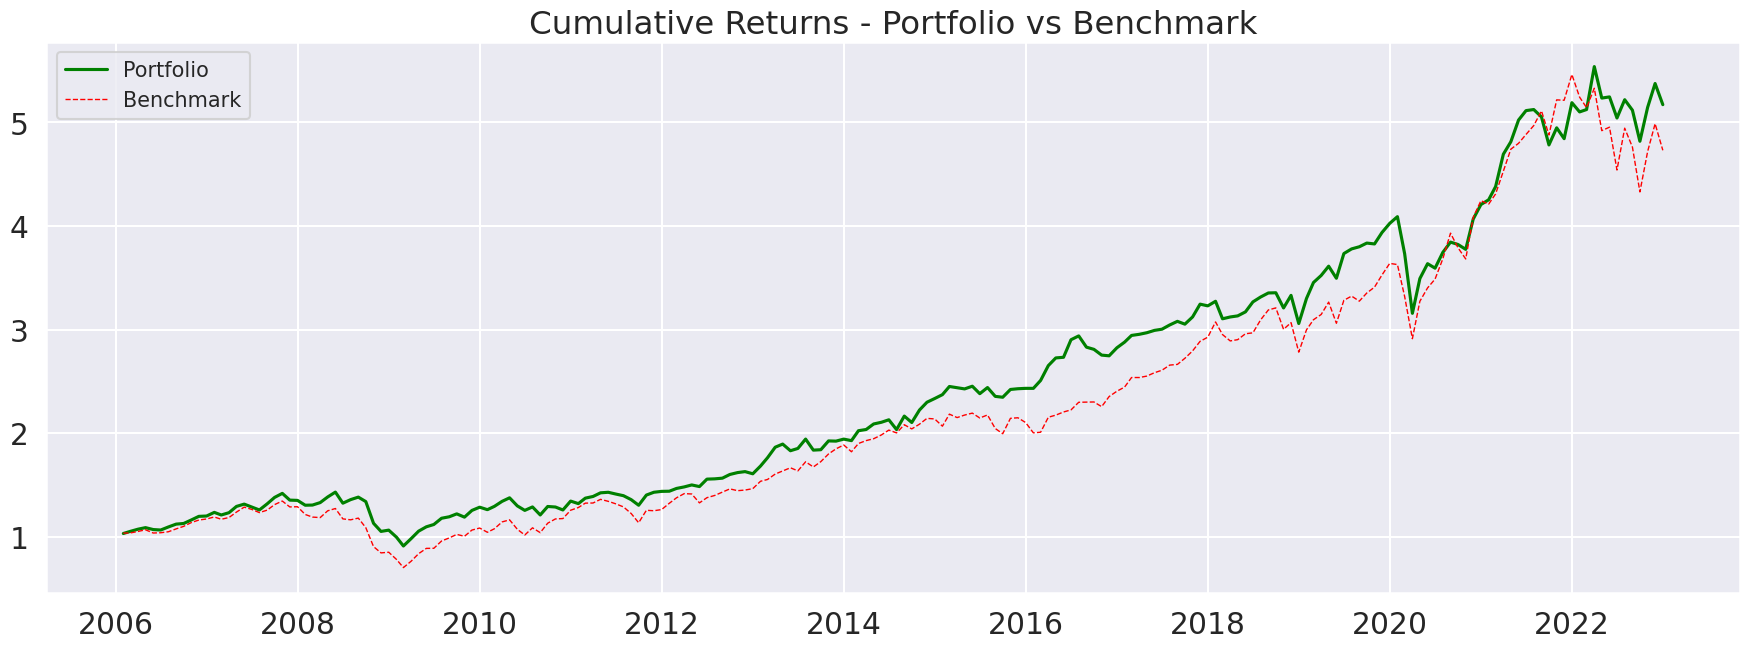

In [32]:
fig, ax = plt.subplots(figsize=(18,7))

ax.title.set_text('Cumulative Returns - Portfolio vs Benchmark')
ax.plot((1+performances.T).cumprod(), color='green', label="Portfolio")
ax.plot((1+mv_perf).cumprod(), color='red', label="Benchmark", lw = 1, linestyle='--')
ax.legend(prop = { "size": 15 })

plt.tight_layout()
plt.show()

#### **Part 2 - Asset Allocation with a Carbon Emissions Reduction**

##### 2. Allocation with a 50% Reduction in Carbon Emissions

In [33]:
scope1_int = pd.read_excel('Data/TC_Scope1Intensity.xlsx', index_col=0)
scope1_int = scope1_int[scope1_int.index.isin(companies.index)].reset_index().set_index('NAME')
scope1_int = scope1_int.iloc[:,7:]

scope1_em = pd.read_excel('Data/TC_Scope1.xlsx', index_col=0)
scope1_em = scope1_em[scope1_em.index.isin(companies.index)].reset_index().set_index('NAME')
scope1_em = scope1_em.iloc[:,7:]

scope2_int = pd.read_excel('Data/TC_Scope2Intensity.xlsx', index_col=0)
scope2_int = scope2_int[scope2_int.index.isin(companies.index)].reset_index().set_index('NAME')
scope2_int = scope2_int.iloc[:,7:]

scope2_em = pd.read_excel('Data/TC_Scope2.xlsx', index_col=0)
scope2_em = scope2_em[scope2_em.index.isin(companies.index)].reset_index().set_index('NAME')
scope2_em = scope2_em.iloc[:,7:]

carbon_em = scope2_em + scope1_em
carbon_int = scope2_int + scope1_int

In [34]:
'''
We can see elow that we have some missing values for 2005 and 2014.

In 2005, we have missing values for the companies:
    * AMERICA S CAR MART
    * APOGEE ENTERPRISES
    * EAGLE MATERIALS
    * RITE AID

In 2014, we have missing values for the company:
    * SUNOPTA (NAS)
'''
print("================== Carbon Intensity - Missing Values ==================")
print(carbon_int.isna().any())
print("================== 2005 ==================")
print(carbon_int.T.loc[2005][carbon_int.T.loc[2005].isna()])
print("================== 2014 ==================")
print(carbon_int.T.loc[2014][carbon_int.T.loc[2014].isna()])

================== Carbon Intensity - Missing Values ==================
2005     True
2006    False
2007    False
2008    False
2009    False
2010    False
2011    False
2012    False
2013    False
2014     True
2015    False
2016    False
2017    False
2018    False
2019    False
2020    False
2021    False
dtype: bool
================== 2005 ==================
NAME
AMERICA S CAR MART   NaN
APOGEE ENTERPRISES   NaN
EAGLE MATERIALS      NaN
RITE AID             NaN
Name: 2005, dtype: float64
================== 2014 ==================
NAME
SUNOPTA (NAS)   NaN
Name: 2014, dtype: float64


In [35]:
'''
We can see elow that we have some missing values for 2005 and 2014.

In 2005, we have missing values for the companies:
    * AMERICA S CAR MART
    * APOGEE ENTERPRISES
    * EAGLE MATERIALS
    * RITE AID

In 2014, we have missing values for the company:
    * SUNOPTA (NAS)
'''
print("================== Carbon Emissions - Missing Values ==================")
print(carbon_em.isna().any())
print("================== 2005 ==================")
print(carbon_em.T.loc[2005][carbon_em.T.loc[2005].isna()])
print("================== 2014 ==================")
print(carbon_em.T.loc[2014][carbon_em.T.loc[2014].isna()])

================== Carbon Emissions - Missing Values ==================
2005     True
2006    False
2007    False
2008    False
2009    False
2010    False
2011    False
2012    False
2013    False
2014     True
2015    False
2016    False
2017    False
2018    False
2019    False
2020    False
2021    False
dtype: bool
================== 2005 ==================
NAME
AMERICA S CAR MART   NaN
APOGEE ENTERPRISES   NaN
EAGLE MATERIALS      NaN
RITE AID             NaN
Name: 2005, dtype: float64
================== 2014 ==================
NAME
SUNOPTA (NAS)   NaN
Name: 2014, dtype: float64


In [36]:
'''
2005: We take the next value as specified in the instruction file.
'''
cies = ['AMERICA S CAR MART', 'APOGEE ENTERPRISES', 'EAGLE MATERIALS', 'RITE AID']
carbon_em.loc[cies, 2005] = carbon_em.loc[cies, 2006]
carbon_int.loc[cies, 2005] = carbon_int.loc[cies, 2006]

'''
2014: We interpolate it
'''
carbon_em.loc['SUNOPTA (NAS)', 2014] = 1/2 * (carbon_em.loc['SUNOPTA (NAS)', 2013] + carbon_em.loc['SUNOPTA (NAS)', 2015])
carbon_int.loc['SUNOPTA (NAS)', 2014] = 1/2 * (carbon_int.loc['SUNOPTA (NAS)', 2013] + carbon_int.loc['SUNOPTA (NAS)', 2015])

In [37]:
print(f'Has the carbon emission dataframe any missing values? {carbon_em.isna().any().any()}')

print(f'\nHas the carbon intensity dataframe any missing values? {carbon_int.isna().any().any()}')

Has the carbon emission dataframe any missing values? False

Has the carbon intensity dataframe any missing values? False


2.1 We compute the weighted average carbon intensity and the carbon footprint:

$$
WACI^{(P)}_{Y} = \sum^{N}_{i=1}\alpha_{i,Y}CI_{i,Y}
$$

$$
CF_{Y}^{(p)} = \sum^{N}_{i=1} o_{i,Y} E_{i,Y}
$$

In [38]:
### WACI ###
'''
Here we compute the Weighted Average Carbon Intensity (WACI) of the portfolio.
We use the weights for Y (computed as of 31.Dec Y) with the carbon intensity of Y.
'''

waci = pd.DataFrame(columns=['Carbon Intensity'], index=range(2006, 2022+1))

for year in range(2006, 2022+1):
    waci.loc[year] = (weights_df.T.loc[year] * carbon_int.T.loc[year-1]).sum()
    
waci

,Carbon Intensity
2006,721.733881
2007,445.104741
2008,640.329014
2009,638.070721
2010,488.474618
2011,214.056744
2012,301.165151
2013,617.256563
2014,480.041972
2015,728.87885


In [39]:
## Carbon Footprint

## Compute the V_{Y} (Dollar value of the Portfolio at year Y)
initial_invest = 1_000_000
vy = pd.DataFrame(index=range(2005,2022+1), columns=['Portfolio Value (in $)'])
x = (1+performances.T).cumprod() * initial_invest

for year in range(2005, 2022+1):
    if year == 2005:
        vy.loc[year] = initial_invest
    else:
        vy.loc[year] = x[x.index.year == year].iloc[-1,:].values[0]

## Compute the V_{i,Y} (Dollar value invested in firm i at year Y)

viy = pd.DataFrame(index=range(2006,2022+1), columns=mv_y.index)

for year in range(2006, 2022+1):
    viy.loc[year] = weights_df.T.loc[year].multiply(vy.loc[year-1].values[0])

## Compute o_{i,Y} (Measure of the fraction of the equity of the firm owned by the portfolio)

oiy = pd.DataFrame(index=range(2006,2022+1), columns=mv_y.index)

for year in range(2006, 2022+1):
    oiy.loc[year] = viy.loc[year] / mv_y.T.loc[year-1]

## Compute the Carbon Footprint of the Portfolio at year Y
cfy = pd.DataFrame(index=range(2006,2022+1), columns=['Carbon Footprint'])

for year in range(2006, 2022+1):
    cfy.loc[year] = (oiy.loc[year] * carbon_em.T.loc[year-1] * 1/vy.loc[year-1].values[0]).sum()


cfy

,Carbon Footprint
2006,388.402874
2007,228.224464
2008,374.929954
2009,474.705694
2010,304.474465
2011,183.401155
2012,243.091828
2013,365.591093
2014,285.766531
2015,418.267319


#### 2.2.1 Optimal long-only portfolio with a carbon footprint 50% below the carbon footprint of the optimal long-only portfolio $P^{(mv)}_{oos}$ determined in point 1.2

$$
\min_{\alpha_{Y}} \quad \sigma^2_{p,Y} = \alpha'_Y\Sigma_{Y+1}\alpha_Y\\


s.t.\quad CF_Y^{(p)} \le 0.5 \times  CF_Y^{(P_{oos}^{(mv)})}\\


s.t.\quad \alpha_{i,Y} \ge 0 \quad \quad \text{for all i}
$$

In [40]:
# Define objective function (portfolio variance)
def portfolio_variance(weights, covmat):
    return np.dot(weights.T, np.dot(covmat, weights))

def carbon_footprint_constraint(weights, year, initial_invest):
    '''
    Function to computes the carbon footprint from the weights
    '''

    if type(weights) != pd.Series:
        weights = pd.Series(weights, index=df_m.columns)
        
    carbonfp = (((weights * initial_invest) / mv_y[year-1]) * carbon_em[year-1] * 1/initial_invest).sum()
    target = cfy.loc[year].values[0] * 0.5

    return -(carbonfp - target)

initial_invest = 1_000_000
weights_dfpf = pd.DataFrame(index=df_m.columns)
vy_dfpf = pd.DataFrame(index=['Money'])
performances_df = []

for year in range(2006, 2022+1):

    vy_dfpf[year-1] = initial_invest

    # Find the covariance matrix
    start = dt.datetime(year-6, 1, 1)
    end = dt.datetime(year-1, 12, 31)
    sample_m = df_m[df_m.index.isin(pd.date_range(start, end))]
    mu_hat = pd.DataFrame(sample_m.mean(axis=0)).T
    excess_returns = sample_m.subtract(mu_hat.values.squeeze(), axis=1)
    covmat = 1/tau * excess_returns.T @ excess_returns

    # Initial guess for weights
    initial_weights = np.ones(595) / 595

    # Optimize it
    result = minimize(portfolio_variance, initial_weights, args=(covmat),
                      constraints=[{'type': 'eq', 'fun': lambda x: np.sum(x)-1},
                                   {'type': 'ineq', 'fun': lambda x, year=year, initial_invest=initial_invest: carbon_footprint_constraint(x, year, initial_invest)}],
                                   bounds = [(0, 1)] * 595)

    optimal_weights = result.x

    # Compute the performance in order to find the final value of the portfolio (that will be used to compute the carbon footprint of the next year)
    returns_year = df_m.loc[df_m.index.year == year]

    ## Alphas
    alpha_data = pd.DataFrame(index=pd.date_range(dt.date(year-1, 12, 31), dt.date(year, 11, 30)), columns=df_m.columns.values)
    alpha_data.index = pd.to_datetime(alpha_data.index)
    alpha_data = alpha_data.resample('M').last().T
    alpha_data.iloc[:,0] = optimal_weights

    for date in range(1, 12):
        for stock in range(595):
            stock_ret = returns_year.iloc[date-1, stock]
            pf_ret = alpha_data.iloc[:, date-1] @ returns_year.iloc[date-1, :]
            previous_alpha = alpha_data.iloc[stock, date-1]
            alpha_data.iloc[stock, date] = previous_alpha * ((1 + stock_ret) / (1 + pf_ret))

    ## Ex-post performance calculation
    performances_fp = pd.DataFrame(index=returns_year.index, columns=returns_year.columns)
    for date in range(12):
        performances_fp.iloc[date, :] = alpha_data.iloc[:, date] * returns_year.iloc[date,:]

    performances_fp = performances_fp.sum(axis=1)
    performances_df.append(performances_fp)

    initial_invest = ((1+performances_fp).cumprod() * initial_invest).values[-1]
    weights_dfpf[year] = optimal_weights

performances_df = pd.concat(performances_df)

In [41]:
## Weights of this portfolio with the carbon footprint constraint
weights_dfpf

,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
SCHLUMBERGER,4.253425e-19,6.142481e-18,4.174121e-18,3.449161e-18,0.000000e+00,4.222158e-19,4.464883e-18,1.668394e-17,2.717980e-18,3.541898e-18,0.000000e+00,3.091830e-18,6.576407e-18,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
ARCH CAP.GP.,3.598092e-04,0.000000e+00,0.000000e+00,0.000000e+00,3.407586e-18,2.352295e-19,6.649296e-03,0.000000e+00,0.000000e+00,0.000000e+00,1.714395e-18,8.526308e-18,3.616462e-03,0.000000e+00,4.504229e-18,1.834676e-18,2.217911e-18
EVEREST GROUP,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.157217e-18,0.000000e+00,0.000000e+00,6.759646e-18,0.000000e+00,1.473917e-03,3.076541e-03,1.863062e-18,1.723017e-02,2.678594e-02,5.256112e-02,4.058580e-02,3.605125e-02
NABORS INDUSTRIES,0.000000e+00,7.955136e-19,0.000000e+00,2.046569e-18,2.200716e-19,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.465184e-18,0.000000e+00,1.504300e-18,0.000000e+00,0.000000e+00,1.687541e-18,0.000000e+00
RENAISSANCERE HDG.,1.598249e-02,2.646735e-02,1.511981e-02,3.132346e-18,3.325776e-18,4.122971e-18,0.000000e+00,8.825083e-04,4.963584e-03,3.598351e-02,1.736124e-02,1.625001e-02,1.494746e-02,1.799650e-02,2.162719e-02,7.033278e-03,2.526682e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XCEL ENERGY,1.329296e-18,2.196490e-19,1.770701e-18,0.000000e+00,1.061707e-18,3.963993e-20,3.767266e-19,1.231768e-18,0.000000e+00,1.299846e-18,1.787540e-18,0.000000e+00,0.000000e+00,7.515925e-19,7.240621e-19,7.952278e-19,0.000000e+00
XEROX HOLDINGS,4.304865e-19,0.000000e+00,7.687940e-19,0.000000e+00,1.978060e-18,0.000000e+00,4.615733e-20,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.556372e-19,6.666602e-20,1.041308e-19,1.790337e-18
YUM! BRANDS,8.000157e-04,0.000000e+00,5.285058e-20,0.000000e+00,0.000000e+00,2.908319e-18,0.000000e+00,0.000000e+00,1.731572e-18,1.418289e-18,1.829667e-19,2.028357e-18,5.405931e-20,1.297128e-18,7.750357e-19,1.725143e-18,1.833361e-19
ZEBRA TECHNOLOGIES 'A',1.847802e-04,4.806889e-20,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.794895e-19,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.380564e-18,7.097618e-19,1.573874e-19,5.961122e-19,0.000000e+00


In [42]:
weights_dfpf[2006].nlargest(20)

HERSHEY                    0.067246
MEDTRONIC                  0.045289
BLACKROCK                  0.044151
VALHI                      0.041399
AGNICO-EAGLE MNS. (NYS)    0.035452
PUBLIC STORAGE             0.034595
PROCTER & GAMBLE           0.033533
LOCKHEED MARTIN            0.031989
IDEXX LABORATORIES         0.029548
IMPERIAL OIL               0.027680
BALL                       0.026987
BOSTON SCIENTIFIC          0.026779
HUNTINGTON BCSH.           0.026288
RB GLOBAL (NYS)            0.025364
MARKEL GROUP               0.025309
VIATRIS                    0.023735
SOUTHERN                   0.022664
UNITED THERAPEUTICS        0.022534
GENERAL MILLS              0.021210
BCE                        0.019867
Name: 2006, dtype: float64

In [43]:
for i in weights_dfpf.columns:
    print('==============',i,'==============')
    print(weights_dfpf[i].nlargest(5))

============== 2006 ==============
HERSHEY                    0.067246
MEDTRONIC                  0.045289
BLACKROCK                  0.044151
VALHI                      0.041399
AGNICO-EAGLE MNS. (NYS)    0.035452
Name: 2006, dtype: float64
============== 2007 ==============
HERSHEY          0.073666
GENERAL MILLS    0.046079
VALHI            0.040189
MEDTRONIC        0.038511
BCE              0.034352
Name: 2007, dtype: float64
============== 2008 ==============
MEDTRONIC         0.053554
HERSHEY           0.050531
GENERAL MILLS     0.045501
FTI CONSULTING    0.043893
STERICYCLE        0.042275
Name: 2008, dtype: float64
============== 2009 ==============
WALMART              0.099647
W R BERKLEY          0.073676
GENERAL MILLS        0.072076
JOHNSON & JOHNSON    0.048349
MEDTRONIC            0.047475
Name: 2009, dtype: float64
============== 2010 ==============
WALMART                 0.110704
STRATEGIC EDUCATION     0.059762
ASSOCIATED BANC-CORP    0.058024
HORMEL FOODS           

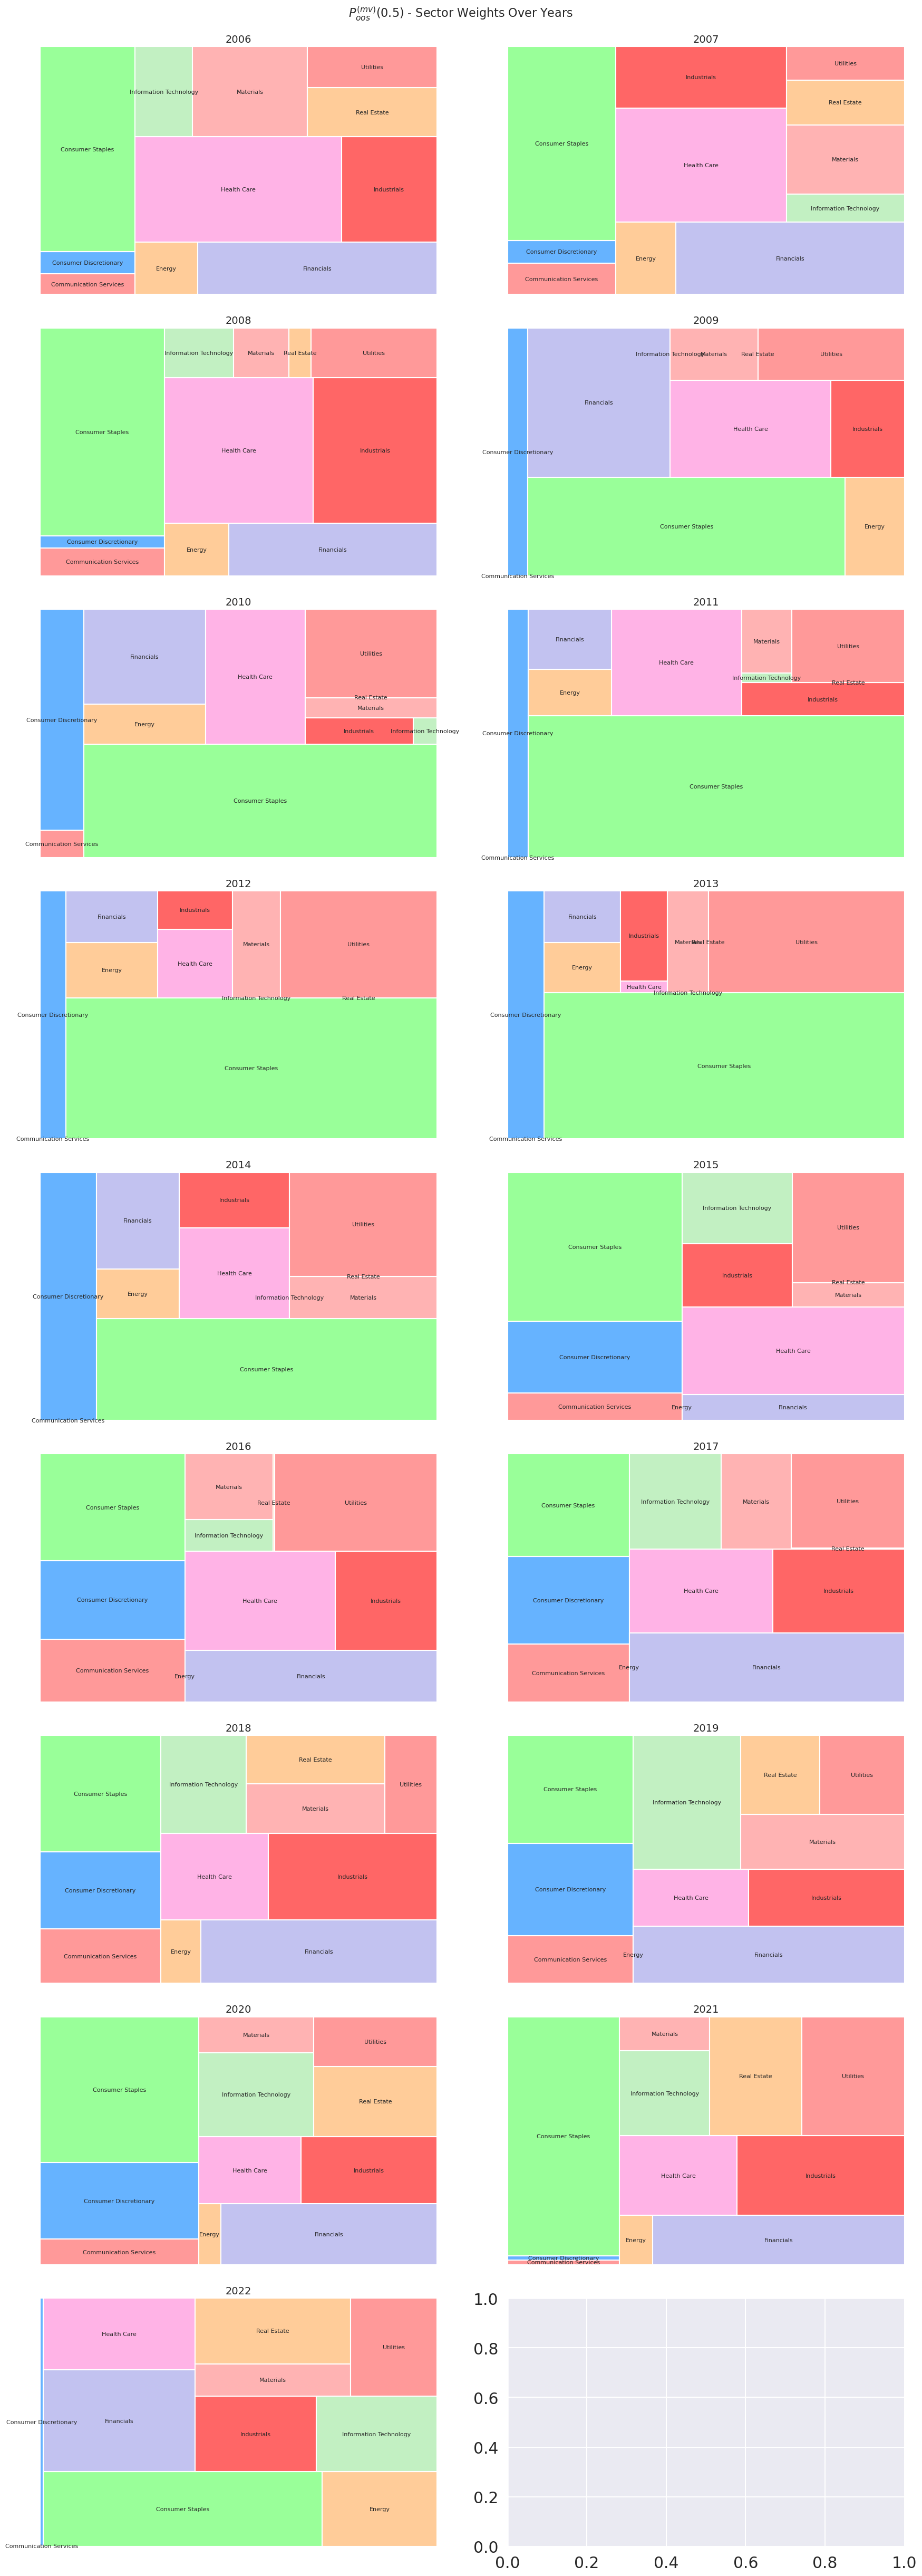

In [44]:
treemap(weights_dfpf, '$P_{oos}^{(mv)}(0.5)$ - Sector Weights Over Years\n\n')

#### 2.2.2  Compute the characteristics of this portfolio, plot the cumulative return series of both strategies, and compare summary statistics.

In [45]:
## Carbon footprint per year of this portfolio
cfy_pfdf = pd.DataFrame(columns=['Carbon footprint'])

for i in range(2006, year+1):
    weights = weights_dfpf[i]
    initial_invest = vy_dfpf[i-1].T.values[0]
    cfy_pfdf.loc[i] = (((weights * initial_invest) / mv_y[i-1]) * carbon_em[i-1] * 1/initial_invest).sum()

cfy_pfdf

,Carbon footprint
2006,194.201437
2007,114.112232
2008,187.464977
2009,237.352847
2010,152.237233
2011,91.700578
2012,121.545914
2013,182.795546
2014,142.883265
2015,209.133660


In [46]:
portfolio_mv05 = portfolio_characteristics(performances_df, 'Portfolio MV(0.5)')
pd.concat([portfolio_mv, portfolio_mv05], axis=1)

,Portfolio MV,Portfolio MV(0.5)
Annualized Average Return,0.105873,0.100933
Annualized Volatility,0.131705,0.12554
Sharpe Ratio,0.723517,0.719699
Minimum,-0.156537,-0.150461
Maximum,0.106319,0.100817
Maximum Drawdown,-0.36387,-0.374489


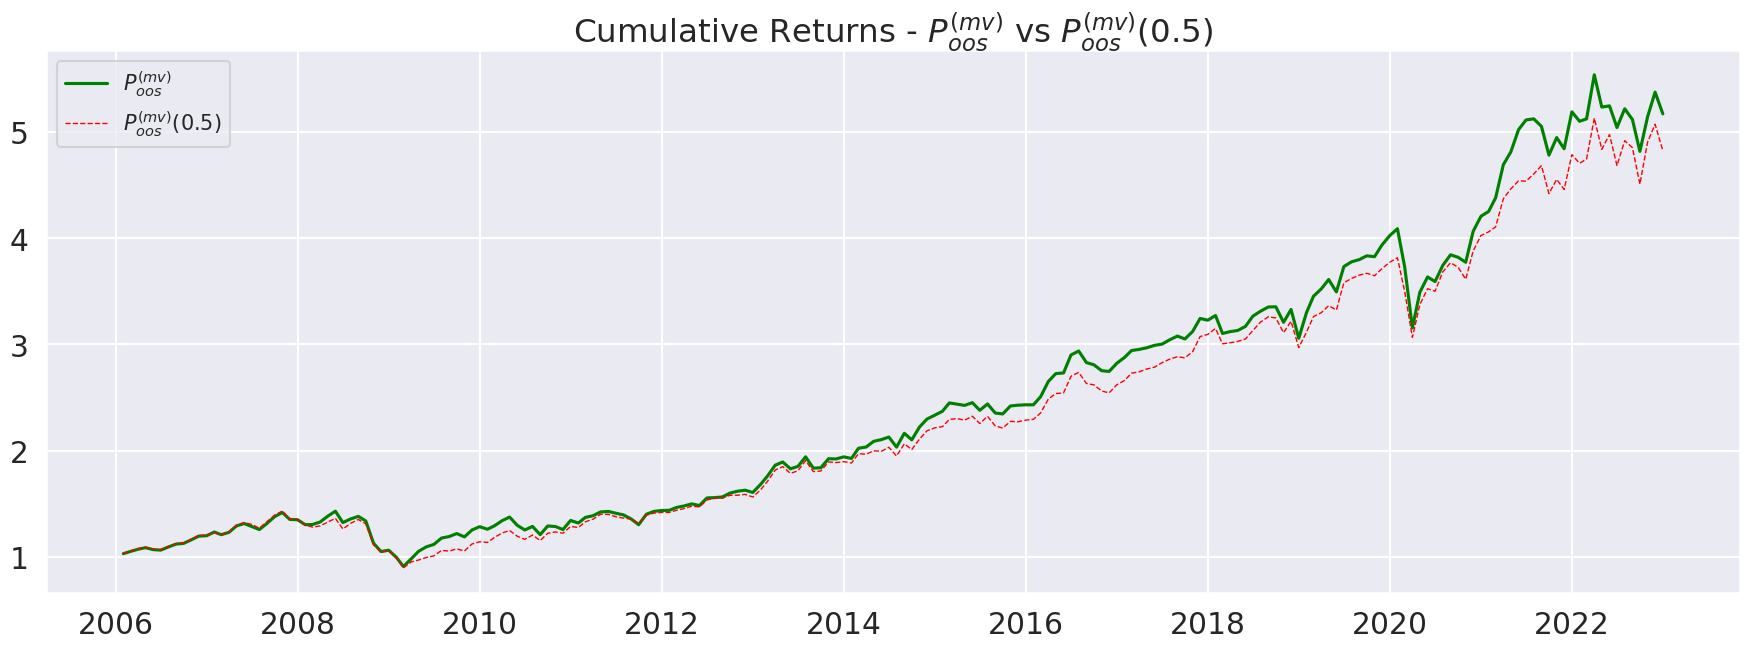

In [47]:
fig, ax = plt.subplots(figsize=(18,7))

portfolio_cumprod = (1 + performances.T).cumprod()
portfolio05_cumprod = (1+performances_df).cumprod()

ax.title.set_text('Cumulative Returns - $P_{oos}^{(mv)}$ vs $P_{oos}^{(mv)}(0.5)$')
ax.plot(portfolio_cumprod, color='green', label="$P_{oos}^{(mv)}$")
ax.plot(portfolio05_cumprod, color='red', label="$P_{oos}^{(mv)}(0.5)$", lw = 1, linestyle='--')
ax.legend(prop = { "size": 15 })

plt.tight_layout()
plt.show()

#### 2.3.1  Compute the benchmark portfolio by maximizing the minimum variance criterion for the tracking error every year

$$
\min_{\alpha_Y} \quad (TE_{p,Y})^2 = (\alpha_Y - \alpha_Y^{(vw)})'\Sigma_{Y+1} (\alpha_Y - \alpha_Y^{(vw)})
\\

s.t.\quad CF_Y^{(p)} \le 0.5 \times  CF_Y^{(P^{(vw)})}\\


s.t.\quad \alpha_{i,Y} \ge 0 \quad \quad \text{for all i}
$$

In [48]:
## Compute the Carbon Footprint of the value-weighted portfolio
capy = mv_y.iloc[:,mv_y.columns.isin(range(2005, 2021+1))].sum()

cfy_vw = 1/capy * carbon_em.sum()
cfy_vw.index = cfy_vw.index + 1

cfy_vw

2006    211.572715
2007    194.834220
2008    197.539390
2009    308.428618
2010    220.243324
2011    205.018909
2012    208.085753
2013    178.922633
2014    141.983130
2015    131.761059
2016    133.093797
2017    129.154509
2018     99.322807
2019    107.203405
2020     81.693766
2021     65.442842
2022     54.353867
dtype: float64

In [49]:
## All the weights for year Y
mv_yearly_weights = mv_weights.T.copy()
mv_yearly_weights.index = pd.to_datetime(mv_yearly_weights.index)
mv_yearly_weights = mv_yearly_weights.resample('Y').last()
mv_yearly_weights.index = mv_yearly_weights.index.year + 1
mv_yearly_weights = mv_yearly_weights.iloc[:-1,:]

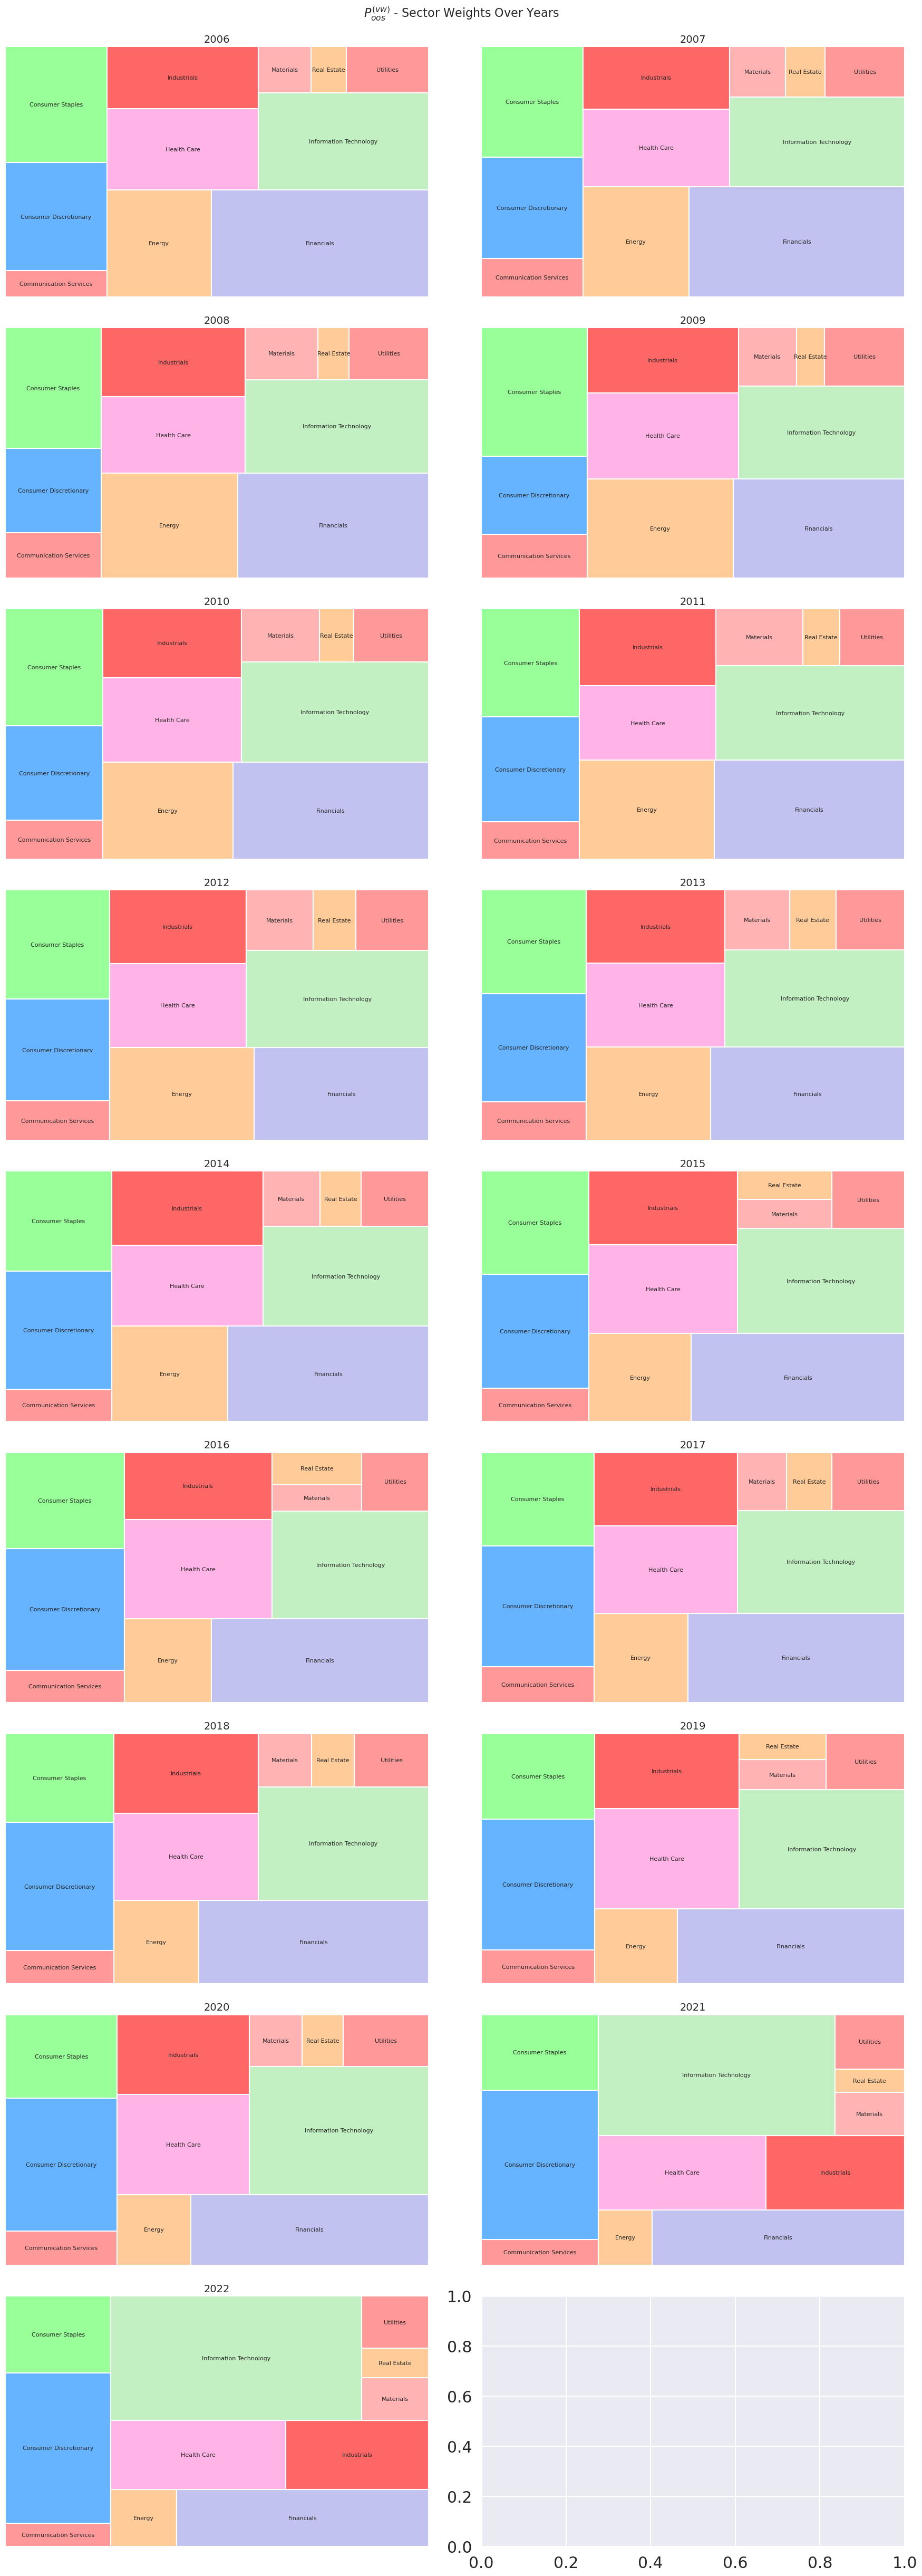

In [50]:
## Treemap of the benchmark (VW)
treemap(mv_yearly_weights.T,'$P_{oos}^{(vw)}$ - Sector Weights Over Years\n\n')

In [51]:
## Let's do the optimization
def tracking_error(weights, covmat, year):
    diff = weights - mv_yearly_weights.loc[year]
    return np.dot(diff.T, np.dot(covmat, diff))

def carbon_footprint_constraint2(weights, year, initial_invest):
    if type(weights) != pd.Series:
        weights = pd.Series(weights, index=df_m.columns)
    
    carbonfp = (((weights * initial_invest) / mv_y[year-1]) * carbon_em[year-1] * 1/initial_invest).sum()
    target = cfy_vw.loc[year] * 0.5

    return -(carbonfp - target)

In [52]:
initial_invest = 1_000_000
weights_pfvw = pd.DataFrame(index=df_m.columns)
vy_vwpf = pd.DataFrame(index=['Money'])
performances_vwdf = []

for year in range(2006, 2022+1):

    vy_vwpf[year-1] = initial_invest

    # Find the covariance matrix
    start = dt.datetime(year-6, 1, 1)
    end = dt.datetime(year-1, 12, 31)
    sample_m = df_m[df_m.index.isin(pd.date_range(start, end))]
    mu_hat = pd.DataFrame(sample_m.mean(axis=0)).T
    excess_returns = sample_m.subtract(mu_hat.values.squeeze(), axis=1)
    covmat = 1/tau * excess_returns.T @ excess_returns

    # Initial guess for weights
    initial_weights = np.ones(595) / 595

    # Optimize it
    result = minimize(tracking_error, initial_weights, args=(covmat, year),
                    constraints=[{'type': 'eq', 'fun': lambda x: np.sum(x)-1},
                                {'type': 'ineq', 'fun': lambda x, year=year,
                                initial_invest=initial_invest: carbon_footprint_constraint2(x, year, initial_invest)}],
                                bounds = [(0, 1)] * 595)

    optimal_weights = result.x

    # Compute the performance in order to find the final value of the portfolio (that will be used to compute the carbon footprint of the next year)
    returns_year = df_m.loc[df_m.index.year == year]

    ## Alphas
    alpha_data = pd.DataFrame(index=pd.date_range(dt.date(year-1, 12, 31), dt.date(year, 11, 30)), columns=df_m.columns.values)
    alpha_data.index = pd.to_datetime(alpha_data.index)
    alpha_data = alpha_data.resample('M').last().T
    alpha_data.iloc[:,0] = optimal_weights

    for date in range(1, 12):
        for stock in range(595):
            stock_ret = returns_year.iloc[date-1, stock]
            pf_ret = alpha_data.iloc[:, date-1] @ returns_year.iloc[date-1, :]
            previous_alpha = alpha_data.iloc[stock, date-1]
            alpha_data.iloc[stock, date] = previous_alpha * ((1 + stock_ret) / (1 + pf_ret))

    ## Ex-post performance calculation
    performances_pf = pd.DataFrame(index=returns_year.index, columns=returns_year.columns)
    for date in range(12):
        performances_pf.iloc[date, :] = alpha_data.iloc[:, date] * returns_year.iloc[date,:]

    performances_pf = performances_pf.sum(axis=1)
    performances_vwdf.append(performances_pf)

    initial_invest = ((1+performances_vwdf[-1]).cumprod() * initial_invest).values[-1]
    weights_pfvw[year] = optimal_weights

performances_vwdf = pd.concat(performances_vwdf)

In [53]:
cfy_vwopt = pd.DataFrame(columns=['Carbon Footprint'])

for year in range(2006, 2022+1):
    weights = weights_pfvw[year]
    initial_invest = vy_vwpf[year-1].values[0]
    cfy_vwopt.loc[year] = (((weights * initial_invest) / mv_y[year-1]) * carbon_em[year-1] * 1/initial_invest).sum()

cfy_vwopt

,Carbon Footprint
2006,105.786358
2007,97.417110
2008,98.769695
2009,153.895401
2010,110.121662
2011,102.509455
2012,104.042877
2013,89.461317
2014,70.640486
2015,65.880529


In [54]:
for i in weights_pfvw.columns:
    print('==============',i,'==============')
    print(weights_pfvw[i].nlargest(5))

============== 2006 ==============
MERCK & COMPANY           0.009827
VERIZON COMMUNICATIONS    0.007294
MICROSOFT                 0.007059
AT&T                      0.006808
QUALCOMM                  0.006602
Name: 2006, dtype: float64
============== 2007 ==============
MERCK & COMPANY           0.009554
AT&T                      0.008421
VERIZON COMMUNICATIONS    0.007739
MICROSOFT                 0.006799
PFIZER                    0.006688
Name: 2007, dtype: float64
============== 2008 ==============
MERCK & COMPANY           0.009425
MICROSOFT                 0.008268
VERIZON COMMUNICATIONS    0.008065
AT&T                      0.007681
EXXON MOBIL               0.007466
Name: 2008, dtype: float64
============== 2009 ==============
MERCK & COMPANY           0.010551
EXXON MOBIL               0.008890
VERIZON COMMUNICATIONS    0.007485
CHEVRON                   0.006883
JOHNSON & JOHNSON         0.006747
Name: 2009, dtype: float64
============== 2010 ==============
APPLE            

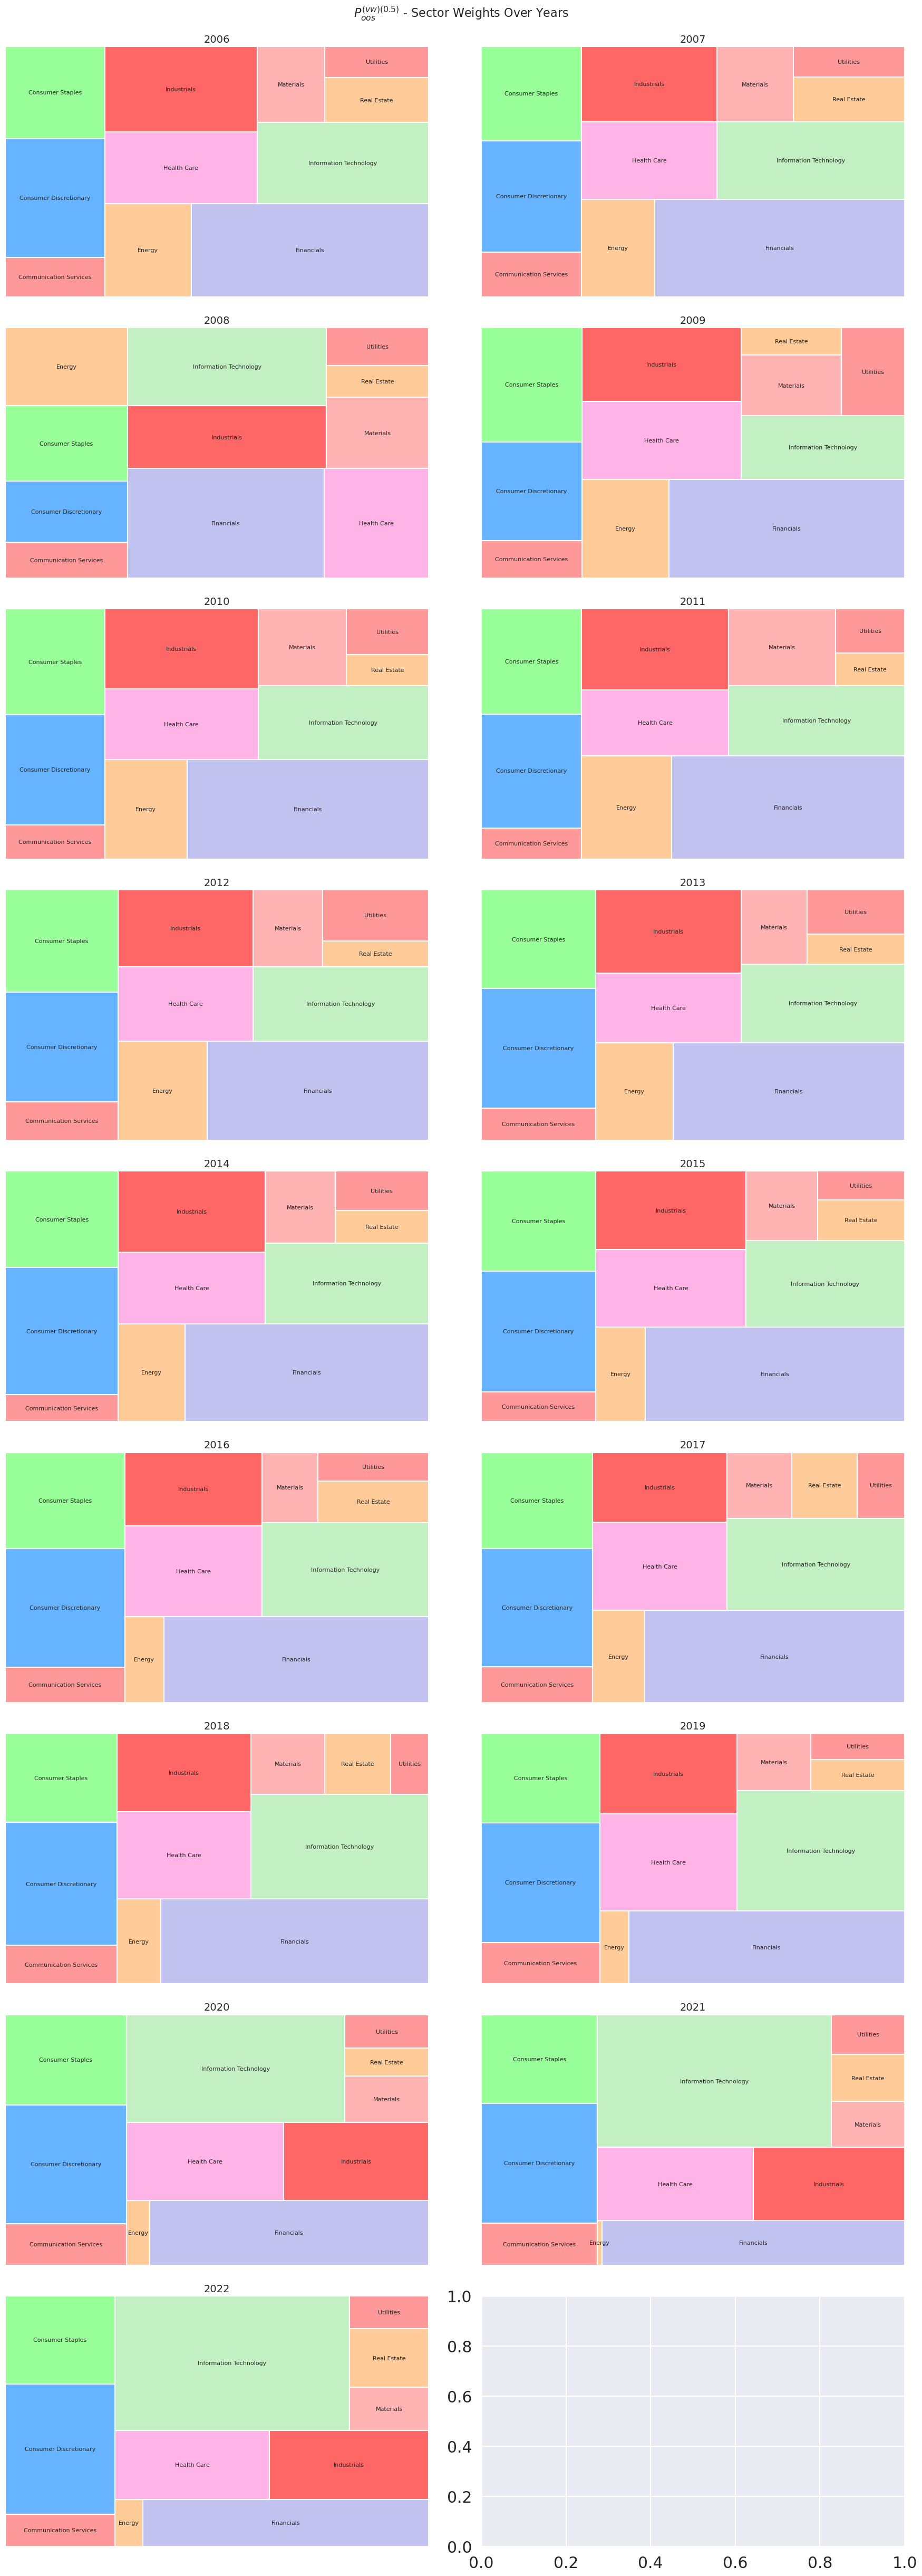

In [55]:
treemap(weights_pfvw, '$P_{oos}^{(vw)(0.5)}$ - Sector Weights Over Years\n\n')

In [56]:
portfolio_vw05 = portfolio_characteristics(performances_vwdf, 'Portfolio (VW) 0.5')
pd.concat([portfolio_vw, portfolio_vw05], axis=1)

,Portfolio VW,Portfolio (VW) 0.5
Annualized Average Return,0.103492,0.10665
Annualized Volatility,0.15219,0.153581
Sharpe Ratio,0.610482,0.625519
Minimum,-0.168004,-0.177211
Maximum,0.124161,0.120754
Maximum Drawdown,-0.478136,-0.467148


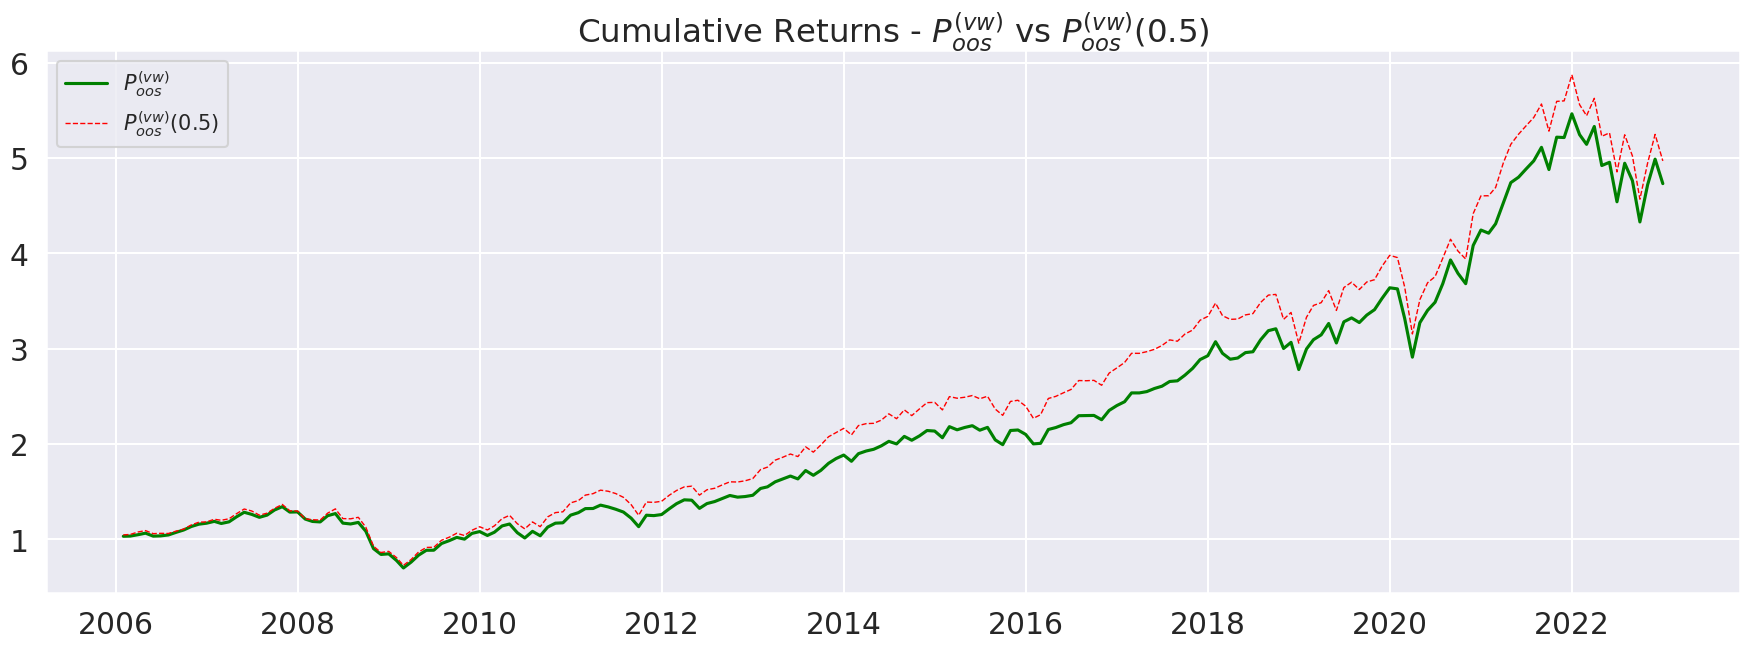

In [57]:
fig, ax = plt.subplots(figsize=(18,7))

portfolio_cumprod = (1 + mv_perf).cumprod()
portfolio05_cumprod = (1+performances_vwdf).cumprod()

ax.title.set_text('Cumulative Returns - $P_{oos}^{(vw)}$ vs $P_{oos}^{(vw)}(0.5)$')
ax.plot(portfolio_cumprod, color='green', label="$P_{oos}^{(vw)}$")
ax.plot(portfolio05_cumprod, color='red', label="$P_{oos}^{(vw)}(0.5)$", lw = 1, linestyle='--')
ax.legend(prop = { "size": 15 })

plt.tight_layout()
plt.show()

#### **Part 3 - Allocation with a Net Zero Objective**

##### 3.1 Decarbonization Strategy

$$
CF_Y^{(p)} \le (1-\theta)^{Y-Y_0+1} \ \times \ CF_{Y_0}^{(P^{(vw)})}
$$

In [58]:
## The optimization problem is the same as in point 2.3 expect that the carbon emissions reduction constraint is now defined as above.
def carbon_reduction_constraint(weights, year, initial_invest):
    if type(weights) != pd.Series:
        weights = pd.Series(weights, index=df_m.columns)
    
    carbonfp = (((weights * initial_invest) / mv_y[year-1]) * carbon_em[year-1] * 1/initial_invest).sum()
    target = cfy_vw.loc[2006] * ((1-0.10) ** (year-2006+1))

    return -(carbonfp - target)

In [59]:
initial_invest = 1_000_000
weights_nz = pd.DataFrame(index=df_m.columns)
vy_nz = pd.DataFrame(index=['Money'])
performances_nz = []

for year in range(2006, 2022+1):

    vy_nz[year-1] = initial_invest

    # Find the covariance matrix
    start = dt.datetime(year-6, 1, 1)
    end = dt.datetime(year-1, 12, 31)
    sample_m = df_m[df_m.index.isin(pd.date_range(start, end))]
    mu_hat = pd.DataFrame(sample_m.mean(axis=0)).T
    excess_returns = sample_m.subtract(mu_hat.values.squeeze(), axis=1)
    covmat = 1/tau * excess_returns.T @ excess_returns

    # Initial guess for weights
    initial_weights = np.ones(595) / 595

    # Optimize it
    result = minimize(tracking_error, initial_weights, args=(covmat, year),
                    constraints=[{'type': 'eq', 'fun': lambda x: np.sum(x)-1},
                                {'type': 'ineq', 'fun': lambda x, year=year, initial_invest=initial_invest: carbon_reduction_constraint(x, year, initial_invest)}],
                                bounds = [(0, 1)] * 595)

    optimal_weights = result.x

    # Compute the performance in order to find the final value of the portfolio (that will be used to compute the carbon footprint of the next year)
    returns_year = df_m.loc[df_m.index.year == year]

    ## Alphas
    alpha_data = pd.DataFrame(index=pd.date_range(dt.date(year-1, 12, 31), dt.date(year, 11, 30)), columns=df_m.columns.values)
    alpha_data.index = pd.to_datetime(alpha_data.index)
    alpha_data = alpha_data.resample('M').last().T
    alpha_data.iloc[:,0] = optimal_weights

    for date in range(1, 12):
        for stock in range(595):
            stock_ret = returns_year.iloc[date-1, stock]
            pf_ret = alpha_data.iloc[:, date-1] @ returns_year.iloc[date-1, :]
            previous_alpha = alpha_data.iloc[stock, date-1]
            alpha_data.iloc[stock, date] = previous_alpha * ((1 + stock_ret) / (1 + pf_ret))

    ## Ex-post performance calculation
    performances_pf = pd.DataFrame(index=returns_year.index, columns=returns_year.columns)
    for date in range(12):
        performances_pf.iloc[date, :] = alpha_data.iloc[:, date] * returns_year.iloc[date,:]

    performances_pf = performances_pf.sum(axis=1)
    performances_nz.append(performances_pf)

    initial_invest = ((1+performances_nz[-1]).cumprod() * initial_invest).values[-1]
    weights_nz[year] = optimal_weights

performances_nz = pd.concat(performances_nz)

In [60]:
initial_invest = 1_000_000
weights_nz = []
vy_nz = pd.DataFrame(index=['Money'])
performances_nz = []

for year in range(2006, 2022+1):

    vy_nz[year-1] = initial_invest

    # Find the covariance matrix
    start = dt.datetime(year-6, 1, 1)
    end = dt.datetime(year-1, 12, 31)
    sample_m = df_m[df_m.index.isin(pd.date_range(start, end))]
    mu_hat = pd.DataFrame(sample_m.mean(axis=0)).T
    excess_returns = sample_m.subtract(mu_hat.values.squeeze(), axis=1)
    covmat = 1/tau * excess_returns.T @ excess_returns

    # Initial guess for weights
    initial_weights = np.ones(595) / 595

    # Optimize it
    result = minimize(tracking_error, initial_weights, args=(covmat, year),
                    constraints=[{'type': 'eq', 'fun': lambda x: np.sum(x)-1},
                                {'type': 'ineq', 'fun': lambda x, year=year, initial_invest=initial_invest: carbon_reduction_constraint(x, year, initial_invest)}],
                                bounds = [(0, 1)] * 595)

    optimal_weights = result.x
    weights_nz.append(optimal_weights)


In [61]:
weights_nz

[array([2.06864035e-03, 1.14799865e-03, 1.12628768e-03, 4.80241785e-04,
        1.08251335e-03, 1.11225536e-03, 1.13442160e-03, 2.10545476e-03,
        0.00000000e+00, 2.17415019e-03, 1.62247975e-03, 1.29158819e-03,
        1.52099185e-03, 1.63197116e-03, 0.00000000e+00, 4.90012591e-03,
        1.67250311e-03, 3.35987196e-03, 6.83901590e-04, 8.76116101e-04,
        5.12404729e-03, 0.00000000e+00, 2.63997422e-03, 2.15246429e-03,
        3.29127652e-03, 3.00558349e-03, 3.52256702e-03, 6.52995810e-04,
        2.67740001e-03, 0.00000000e+00, 3.68882849e-19, 1.22176353e-03,
        1.27387634e-03, 6.93386793e-04, 0.00000000e+00, 6.36837399e-04,
        9.35689037e-05, 1.34465819e-03, 9.07131473e-04, 2.51697385e-03,
        1.18072075e-03, 3.24014142e-03, 0.00000000e+00, 1.97149085e-03,
        3.95987903e-19, 1.36853379e-03, 1.09347306e-03, 1.18330542e-03,
        2.24032426e-03, 1.80115591e-03, 1.37155260e-03, 6.67038446e-20,
        2.47757137e-20, 2.36547745e-03, 1.92374288e-03, 1.851316

In [62]:
alphas_test_df = pd.DataFrame()

for year in range(2006, 2022+1):
    alpha_test = pd.DataFrame(index=pd.date_range(dt.date(year-1, 12, 31), dt.date(year, 11, 30)), columns=df_m.columns.values)
    alpha_test.index = pd.to_datetime(alpha_test.index)
    alpha_test = alpha_test.resample('M').last().T
    alpha_test.iloc[:,0] = weights_nz[year]

    sample_test = df_m[df_m.index.isin(pd.date_range(dt.date(year, 1, 1), dt.date(year, 12, 31)))].T

    for time in range(1, 12):
        for stock in range(595):
            stock_ret = sample_test.iloc[stock, time-1]
            perf_ret = sample_test.iloc[:, time-1] @ weights_nz[year]
            alpha_test.iloc[stock, time] = alpha_test.iloc[stock, time-1] * (1 + stock_ret) / (1 + perf_ret)

    # Concatenate the current alpha_test to alphas_test_df
    alphas_test_df = pd.concat([alphas_test_df, alpha_test], axis=1)

IndexError: list index out of range

In [ ]:
alphas_test_df

In [ ]:
performances.T

In [ ]:
pd.concat([test_two, alpha_test], axis=1)

In [ ]:
cfy_nz = pd.DataFrame(columns=['Carbon Footprint'])

for year in range(2006, 2022+1):
    weights = weights_nz[year]
    initial_invest = vy_nz[year-1].values[0]
    cfy_nz.loc[year] = (((weights * initial_invest) / mv_y[year-1]) * carbon_em[year-1] * 1/initial_invest).sum()

cfy_nz

In [ ]:
for i in weights_nz.columns:
    print('==============',i,'==============')
    print(weights_nz[i].nlargest(5))

In [ ]:
treemap(weights_nz, '$P_{oos}^{(vw)}(NZ)$ - Sector Weights Over Years\n\n')

In [ ]:
portfolio_nz = portfolio_characteristics(performances_nz, 'Portfolio (VW)(NZ)')
pd.concat([portfolio_vw, portfolio_vw05, portfolio_nz], axis=1)

In [ ]:
fig, ax = plt.subplots(figsize=(18,7))

bench_cumprod = (1 + mv_perf).cumprod()
portfolio05_cumprod = (1+performances_vwdf).cumprod()
portfolionz_cumprod = (1+performances_nz).cumprod()

ax.title.set_text('Cumulative Returns - $P_{oos}^{(vw)}$ vs. $P_{oos}^{(vw)}(0.5)$ vs. $P_{oos}^{(vw)}(NZ)$')
ax.plot(bench_cumprod, color='green', label="$P_{oos}^{(vw)}$")
ax.plot(portfolio05_cumprod, color='red', label="$P_{oos}^{(vw)}(0.5)$", lw = 1.5)
ax.plot(portfolionz_cumprod, color='blue', lw=1,  label="$P_{oos}^{(vw)}(NZ)$")
ax.legend(prop = { "size": 15 })

plt.tight_layout()
plt.show()